## Dataset I. target_dataset
<br>
<img src="./images/target_dataset.png"/>

Explanation for the columns:
1. `person` (int)
    - Id for person: already encoded to int number
2. `offer_id` (object of str)
    - Id for offer: already encoded to int number
    - **Values**: from '0' to '9'
3. `time_received` (float)
    - time of reveiving the offer
    - **Values**: `NaN` represent not received
4. `time_viewed` (float) 
    - time of viewing the offer
    - **Values**: `NaN` represent not viewed
5. `time_transaction` (object of str)
    - time of the transactions within an transaction unit(within one unique offer_id of one person, there may be more transaction units)
    - **Values**: there maybe more than one transactions within a transaction unit, so use `str`(obeject) to represent
        - `''` means there is no transaction
        - `',3.8,5.9'` means there is two transactions, one is at time 3.8, another in at time 5.9
6. `time_completed` (float)
    - time of complete the offer
    - **Values**: `NaN` represent not completed
7. `amount_with_offer` (float)
    - amount of transaction(s) within this transaction unit
    - **Values**: '0.0' represent no transaction
8. `label_effective_offer` (int) **!!!Attention: has no infomation about 'offer viewed'**
    - the label to mark the completion level of offer
    - **Values**:
        - `1`: 
            - for informational offer there is at least one transaction within duration; 
            - for other offer there should be 'offer completed'
        - `0`: 
            - for informational offer there is no valid transaction within the duration but 'offer received'; 
            - for other offers there is no 'offer completed', but within duration there maybe some amount, although the amount of transactions not fulfil requirements
        - `-1`: the init label, when there is no 'offer received', the label keeps '-1'
        - `-2`: Special, some interesting discovering after the data was wrangled
            - represent some people: they only have transactions within all the experimantal time , no offer was sent to them(this situation appears because some person haven't received any offer)

## Dataset II. transcript_offer(updated)

```python
### Code
# Just show the updated part:
normal_offer_id = target_dataset.offer_id.unique().tolist()   # ['0','1','2','3','4','5','6','7','8','9']
# show transaction, the offer_id is not normal(some has been updated by wrangling)
transcript_offer[~transcript_offer.offer_id.isin(normal_offer_id)].tail(20)
```
<img src="./images/transcript_offer.png"/>
Some values in column 'offer_id' are updated.<br>
In figure, the value '6,5' represent:<br>
　　this transaction is valid for two offer_ids: one is '6', another is '5'.

# <a class="anchor" id="0">Table of Contents</a>

I. [Feature Engineer](#1)<br>
II.[Segement of the Person](#2)<br>
III.[Classes of responsiveness to the offers](#3)<br>
　　3.1. [NAME](#3.1)<br>
　　　　Method.1 [NAME](#3.1.1)<br>
　　　　Method.2 [NAME](#3.1.2) (better for debugging)<br>
　　3.2. [Save the wrangled data](#3.2)<br>
IV.[Explore the wrangled Data](#4)(preliminary)<br>
[References](#References)

### Imports & Load in data

In [1]:
import pandas as pd
import numpy as np
import math
import json

from time import time
from datetime import date
from collections import defaultdict

import seaborn as sb
import matplotlib.pyplot as plt
%matplotlib inline

# detail for offers
portfolio_raw = pd.read_csv('./data_generated/cleaned_portfolio.csv', dtype={'offer_id': str})
del portfolio_raw['Unnamed: 0']

# detail for person
profile_raw = pd.read_csv('./data_generated/cleaned_profile.csv')
del profile_raw['Unnamed: 0']

# wrangled transcript with updated information of offer
transcript_offer_raw = pd.read_csv('./data_generated/wrangled_transcript_offer.csv', dtype={'person': int})
# recover to original dataset: index is the same
transcript_offer_raw.index = transcript_offer_raw.iloc[:, 0].values
del transcript_offer_raw['Unnamed: 0']

# wrangled ideal target_dataset
target_dataset_raw = pd.read_csv('./data_generated/modified_wrangled_target_dataset.csv', dtype={'person': int, 'offer_id': str})
# recover to original dataset: index is the same
target_dataset_raw.index = target_dataset_raw.iloc[:, 0].values
del target_dataset_raw['Unnamed: 0']

In [2]:
portfolio = portfolio_raw.copy()
profile = profile_raw.copy()
transcript_offer = transcript_offer_raw.copy()
target_dataset = target_dataset_raw.copy()

## <a class="anchor" id="1">[I. Feature Engineer](#0)</a>

### 1. Potential feature 
- Transform column 'became_member_on' in `profile`

In [3]:
# rename column for merging
profile.rename(columns={'id': 'person'}, inplace=True)

In [4]:
def transform_date(input_date):
    '''Transform date(int) to normal date(date form)
    '''
    year = int(str(input_date)[:4])
    month = int(str(input_date)[4:6])
    day = int(str(input_date)[-2:])
    actual_date = date(year, month, day)
    
    return actual_date

In [5]:
# create funciton to transform the register date to member_days 
latest_date = profile['became_member_on'].max()  #20180726

def transform_member_days(input_date, latest_date):
    '''Transform the register date to member_days.
    
    INPUT:
        - date (int): the register date, e.g. 20180726
        - latest_date (int): the latest register date, 20180726
    
    OUTPUT:
        - member_days (int): the days apart from the latest new year, 2019.01.01
    '''
    # suppose we use the begin of the next year as the experimental date, here is 2019.01.01
    latest_year = int(str(latest_date)[:4]) + 1  # 2019: used to calculate
    refer_date = date(latest_year, 1, 1)
    
    year = int(str(input_date)[:4])
    month = int(str(input_date)[4:6])
    day = int(str(input_date)[-2:])
    actual_date = date(year, month, day)
    
    # get the date difference to the refer_date
    member_days = (refer_date - actual_date).days

    return member_days


profile['member_days'] = profile['became_member_on'].apply(transform_member_days, args=(latest_date,))
profile['register_date'] = profile['became_member_on'].apply(transform_date)

profile

,gender,age,person,became_member_on,income,member_days,register_date
0,F,55,1,20170715,112000.0,535,2017-07-15
1,F,75,3,20170509,100000.0,602,2017-05-09
2,M,68,5,20180426,70000.0,250,2018-04-26
3,M,65,8,20180209,53000.0,326,2018-02-09
4,M,58,12,20171111,51000.0,416,2017-11-11
...,...,...,...,...,...,...,...
14820,F,45,16995,20180604,54000.0,211,2018-06-04
14821,M,61,16996,20180713,72000.0,172,2018-07-13
14822,M,49,16997,20170126,73000.0,705,2017-01-26
14823,F,83,16998,20160307,50000.0,1030,2016-03-07


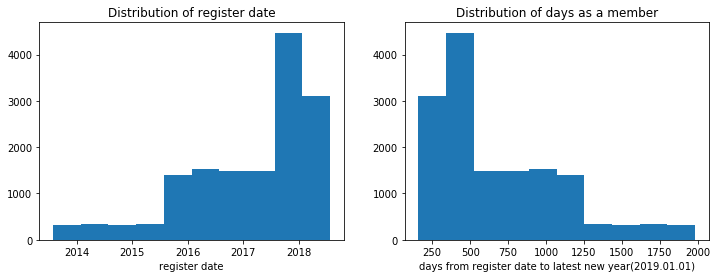

In [6]:
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.hist(data=profile, x='register_date')
plt.title('Distribution of register date')
plt.xlabel('register date')

plt.subplot(1,2,2)
plt.hist(data=profile, x='member_days')
plt.title('Distribution of days as a member')
plt.xlabel('days from register date to latest new year(2019.01.01)')

plt.show()

# after visualization delete useless columns
profile.drop(columns=['became_member_on', 'register_date'], inplace=True )

In [7]:
profile

,gender,age,person,income,member_days
0,F,55,1,112000.0,535
1,F,75,3,100000.0,602
2,M,68,5,70000.0,250
3,M,65,8,53000.0,326
4,M,58,12,51000.0,416
...,...,...,...,...,...
14820,F,45,16995,54000.0,211
14821,M,61,16996,72000.0,172
14822,M,49,16997,73000.0,705
14823,F,83,16998,50000.0,1030


### 2. Merge the dataset to combine all the potential features 

In [8]:
target_dataset = target_dataset.merge(portfolio, how='left', on='offer_id').merge(profile, how='left', on='person')

## <a class="anchor" id="2">[II. Segement of the Person](#0)</a>
Since there are too many individuals, it's better to set some customer groups to excavate more common pattern in each group.<br>
According to [References[1]](https://github.com/syuenloh/UdacityDataScientistCapstone/blob/master/Starbucks%20Capstone%20Challenge%20-%20Using%20Starbucks%20app%20user%20data%20to%20predict%20effective%20offers.ipynb) and [References[3]](https://www.pewresearch.org/topics/generations-and-age/), there is a definition of generations based on age in 2019.
<img src="./images/generations_age.png"/>

### 1. Segment of target_dataset based on 'age' and 'gender' 

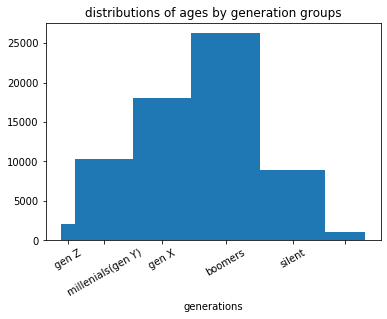

In [9]:
# distribution of age according to the definition of generations
# in 2018 the age edge as bins
age_min=target_dataset.age.min()  #18
age_max=target_dataset.age.max() #101
bins = [age_min, 22, 38, 54, 73, 91, age_max+1]
plt.hist(data=target_dataset, x='age' ,bins=bins);

plt.title('distributions of ages by generation groups')
plt.xlabel('generations')

ticks_loc = [20, 30, 46, 63.5, 82, 96.5]
ticks_label = ['gen Z', 'millenials(gen Y)', 'gen X', 'boomers', 'silent']
plt.xticks(ticks_loc, ticks_label, rotation=30) #rotation=90

plt.show()

Meantime, we can use also other informations(gender, income, member_days etc.) together to divide customer groups.<br>
Since the groups of `gen Z`(18-21) and the elder than `silent` are small, and the age is closed to the generation group nearby, so we finally make the segement as follows:
- age
- gender

|Segment #| Age Group (edge included)<br> (Experiment in 2018) | Gender | 
|---| --- | --- | 
|1| Millenials(-21 & 22-37) | M | 
|2| Millenials(-21 & 22-37) | F | 
|3| Millenials(-21 & 22-37) | O | 
|4| Gen X(38-53) | M|
|5| Gen X(38-53) | F|
|6| Gen X(38-53) | O|
|7| Baby Boomer(54-72) | M|
|8| Baby Boomer(54-72) | F|
|9| Baby Boomer(54-72) | O|
|10| Silent(73-90 & 91+) | M|
|11| Silent(73-90 & 91+) | F|
|12| Silent(73-90 & 91+) | O|

In [10]:
def segment_person(target_dataset):
    '''Make a segment to target_dataset.
    
    INPUT:
        - target_dataset(DataFrame)
    OUTPUT:
        - df_segments(list of DataFrame)
    '''
    df_segments=[]
    is_gender_M = (target_dataset.gender == 'M')
    is_gender_F = (target_dataset.gender == 'F')
    is_gender_O = (target_dataset.gender == 'O')
    
    age_min=target_dataset.age.min()  #18
    age_max=target_dataset.age.max() #101
    bins_begin = [age_min, 38, 54, 73]
    bins_end  = [38, 54, 73, age_max+1]
    for ages_begin, ages_end in zip(bins_begin, bins_end):
        is_generation = (target_dataset.age >= ages_begin) & (target_dataset.age < ages_end)
        df_segments.append(target_dataset[is_generation][is_gender_M])
        df_segments.append(target_dataset[is_generation][is_gender_F])
        df_segments.append(target_dataset[is_generation][is_gender_O])
    
    return df_segments 

df_segments = segment_person(target_dataset)

D:\JustPractice\1_MS_Geek_salute\PythonAnaconda\lib\site-packages\ipykernel_launcher.py:20: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
D:\JustPractice\1_MS_Geek_salute\PythonAnaconda\lib\site-packages\ipykernel_launcher.py:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
D:\JustPractice\1_MS_Geek_salute\PythonAnaconda\lib\site-packages\ipykernel_launcher.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


In [11]:
count_segments = []
for idx in range(0, 12):
    count_segments.append(df_segments[idx].shape[0])

In [12]:
count_segments

[8603, 3659, 127, 10718, 6986, 290, 14192, 11698, 357, 4617, 5117, 142]

[Text(0, 0, 'Millenials'),
 Text(0, 0, 'Gen X'),
 Text(0, 0, 'Boomer'),
 Text(0, 0, 'Silent')]

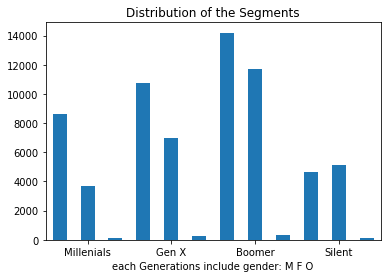

In [13]:
ax = (pd.Series(count_segments)).plot(kind="bar", rot=0);
xticks_loc = range(1, 11, 3)
xticks_label = ['Millenials', 'Gen X', 'Boomer', 'Silent']

ax.set_title('Distribution of the Segments')
ax.set_xlabel('each Generations include gender: M F O')
ax.set_xticks(xticks_loc)
ax.set_xticklabels(xticks_label)

- Get the DataFrames of segment `df_segments[0...11]`
- FOUND
    - the distribution of gender is huge unbalanced because of less number of gender 'O'. For heuristic analyzation is not a big problem.

## <a class="anchor" id="3">[III. Classes of responsiveness to the offers](#0)</a>
The all possible responsiveness defined as follows:<br>

|Group| received | viewed |valid completed | transaction amount |Scenario |
| :-| :-: | :-:| :-: | :-: | :- |
|1.none_offer| 0 | 0 | 0 | |haven't received the offer |
|2.no_care | 1 | 0 | - | |received but not viewed.<br> regarded as no_care|
|| 1 | 1 | 0 | =0.0 | received, viewed but no transaction |
|| 1 | 1 | 1<br>viewed after completed |  | received, but completed unintentionally |
|3.tried| 1 | 1 | 0 | >0.0|received, viewed, have transaction |
|4.effctive_offer | 1 | 1 | 1<br>viewed before completed | | viewed before completed,  effctive offer|

**NOTE：**
1. **'valid completed'**, means complete within the duration of the offer<br>
2. States like 0,0,1 or 0,1,0 or 0,1,1 are impossible in reality.
3. `label_effective_offer == '1'` means received and valid completed<br>
(More details at the begining of explanation for the datasets)

1. `none_offer`(passive)<br>
    - I. not viewed, no matter received or not.
        - `time_viewed` == NaN
2. `no_care`(active)<br>
    - I. reveived, viewed, but no transaction
        - `label_effective_offer` == '0' & `amount` == 0.0 & `time_viewed`.notnull() 
    - or II. received, viewed, completed but viewed time after completed time
        - `label_effective_offer` == '1' & `time_viewed` > `time_completed` #when time_viewed is NaN, always False
3. `tried`<br>
    - I. received, viewed, have transaction but not valid completed
        - `label_effective_offer` == '0' & `amount` > 0.0  & `time_viewed`.notnull() 
4. `effctive_offer`<br>
    - I. received, viewed, and completed, besides viewed time before completed time
        - `label_effective_offer` == '1' & `time_viewed` < `time_completed` #when time_viewed is NaN, always False

### 1. Divide the response into 4 groups

In [14]:
def group_none_offer(list_dfs):
    '''
    '''
    # viewed time is NaN
    grouped_segment = []
    for df_segment in list_dfs:
        is_group = df_segment.time_viewed.isna()  #.isnull() .isna(); np.nan()
        grouped_segment.append(df_segment[is_group])
    
    return grouped_segment

In [15]:
def group_no_care(list_dfs):
    '''
    '''
    # 
    grouped_segment = []
    for df_segment in list_dfs:
        is_group_no_trans = (df_segment.label_effective_offer == 0) & (df_segment.amount_with_offer == 0)  & (df_segment.time_viewed.notnull())#0和0.0没有区别
        is_group_later_view = (df_segment.label_effective_offer == 1) & (df_segment.time_viewed > df_segment.time_completed) 
        is_group = is_group_no_trans | is_group_later_view
        grouped_segment.append(df_segment[is_group])
    
    return grouped_segment

In [16]:
def group_tried(list_dfs):
    '''
    '''
    #
    grouped_segment = []
    for df_segment in list_dfs:
        is_group = (df_segment.label_effective_offer == 0) & (df_segment.amount_with_offer > 0) & (df_segment.time_viewed.notnull())
        grouped_segment.append(df_segment[is_group])
    
    return grouped_segment

In [17]:
def group_effctive_offer(list_dfs):
    '''
    '''
    #
    grouped_segment = []
    for df_segment in list_dfs:
        is_group = (df_segment.label_effective_offer == 1) & (df_segment.time_viewed <= df_segment.time_completed) 
        grouped_segment.append(df_segment[is_group])
    
    return grouped_segment

In [18]:
# list of segment DataFrame in none_offer group
# you can check:all time_viewed are NaNs
none_offer_segments = group_none_offer(df_segments)

# list of segment DataFrame in no_care group
# you can check: some time_viewed is after time_completed
no_care_segments = group_no_care(df_segments)

# list of segment DataFrame in tried group
tried_segments = group_tried(df_segments)

# list of segment DataFrame in no_care group
effctive_offer_segments = group_effctive_offer(df_segments)

### 2. CHECK the dividing method for the 4 groups of response to offer

In [23]:
# CHECK the 12 segments: the number of records are same XXXX
segment_records =[]
for df in df_segments:
    segment_records.append(df.shape[0])

print(sum(segment_records))
segment_records  #segments data

66506


[8603, 3659, 127, 10718, 6986, 290, 14192, 11698, 357, 4617, 5117, 142]

In [25]:
# CHECK the method of dividing the 4 groups of response:
# each segment(DataFrame) should have the same number of records
group_records = []
for idx in range(0,12):
    size = none_offer_segments[idx].shape[0] + no_care_segments[idx].shape[0]+tried_segments[idx].shape[0]+effctive_offer_segments[idx].shape[0]
    group_records.append(size)

print(sum(group_records))
group_records

66506


[8603, 3659, 127, 10718, 6986, 290, 14192, 11698, 357, 4617, 5117, 142]

- Conclusion from the result: <br>
the dividing method is correct.

### 3. Heuristic exploration in 4 aspects

#### `3.1` Offer Distributions: none_offer VS. others

In [ ]:
# none_offer_segments
offer_segments = pd.concat([no_care_segments[1], tried_segments[1], effctive_offer_segments[1]], axis=0)
def segment_2_offers(df_segment):
    '''
    ax: Segment
    xaxis: 10 offer
    yaxis: statistik
    '''
    
    # concat合并其他三个组
    

In [ ]:
def all_segment_2_offers():

In [ ]:
ax = (pd.Series(count_segments)).plot(kind="bar", rot=0);
xticks_loc = range(1, 11, 3)
xticks_label = ['Millenials', 'Gen X', 'Boomer', 'Silent']

ax.set_title('Distribution of the Segments')
ax.set_xlabel('each Generations include gender: M F O')
ax.set_xticks(xticks_loc)
ax.set_xticklabels(xticks_label)

In [ ]:
offer_segments = pd.concat([no_care_segments[1], tried_segments[1], effctive_offer_segments[1]], axis=0)


In [ ]:
offer_segments

In [ ]:
target_dataset

In [ ]:
is_test = (target_dataset.label_effective_offer == 1)
target_dataset[is_test].time_viewed

In [ ]:
(target_dataset[is_test].time_viewed >=0).all()

In [ ]:
a=~(ser>=0)

In [ ]:
ser =target_dataset[is_test].time_viewed
ser[a].index

In [ ]:
b = target_dataset.loc[ser[a].index]

In [ ]:
(b.time_completed >= 0).all()

## <a class="anchor" id="References">[References](#0)</a>
[[1]Starbucks Capstone Challenge: Using Starbucks app user data to predict effective offers](https://github.com/syuenloh/UdacityDataScientistCapstone/blob/master/Starbucks%20Capstone%20Challenge%20-%20Using%20Starbucks%20app%20user%20data%20to%20predict%20effective%20offers.ipynb)<br>
[[2]Starbucks Promotion Optimization](https://towardsdatascience.com/starbucks-promotion-optimization-ca56e29fb584)<br>
[[3]generations-and-age](https://www.pewresearch.org/topics/generations-and-age/)<br>
[[4]single taxable income](https://en.wikipedia.org/wiki/Income_tax_in_the_United_States#Marginal_tax_rates_for_2019)

According to [References[4]](https://en.wikipedia.org/wiki/Income_tax_in_the_United_States#Marginal_tax_rates_for_2019), we get the `single taxable income` of Americans in 2018.
<img src='./images/tax.png'>

In [ ]:
min_income = target_dataset.income.min() #30,000
max_income = target_dataset.income.max() #120,000

bins = [min_income, 38701, 82501, max_income+1]
target_dataset.income.hist(bins=bins)

# 补充
```python
#no need after BUG fixed
# update time_completed for informational effctive offers
# for informational offer, time_transaction(only one) is time_completed
is_change_time_complete = (target_dataset.offer_id.isin(['2','7'])) & (target_dataset.label_effective_offer == 1)
target_dataset.loc[is_change_time_complete, 'time_completed'] = target_dataset[is_change_time_complete]['time_transaction'].apply(lambda x: float(x))
```
1. 更新target_dataset中informational offer的time_complete
2. 替换column中subset的值
    - using .loc[row_indexer,col_indexer] = value instead
3. element-wise logical-and. That is what the & binary operator performs
4. 含nan的判断都是Fasle
    - 1.3>=np.nan
    - 1.3<=np.nan
    - np.nan<=1.3
    - np.nan==np.nan
5. 再次检查数据处理的程序
    - 其他offer,completed标志保障了：there must be transaction(s) & amount >= difficulty